In [1]:
#在PyTorch中构建神经网络模型
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.onnx.symbolic_opset9 import tensor
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch.nn as nn
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split 
from scipy.special import expit

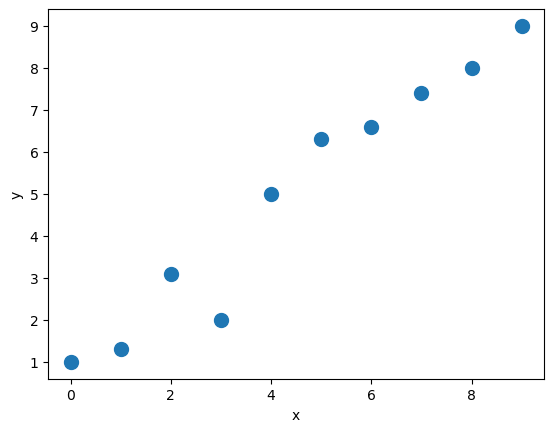

In [2]:
#构建线性回归模型
X_train = np.arange(10, dtype='float32').reshape((10, 1))
y_train = np.array([1.0, 1.3, 3.1, 2.0, 5.0, 6.3, 6.6, 
                    7.4, 8.0, 9.0], dtype='float32')

plt.plot(X_train, y_train, 'o', markersize=10)
plt.xlabel('x')
plt.ylabel('y')

plt.show()

In [3]:
X_train_norm = (X_train - np.mean(X_train)) / np.std(X_train)
X_train_norm = torch.from_numpy(X_train_norm)
y_train = torch.from_numpy(y_train).float()

In [4]:
train_ds = TensorDataset(X_train_norm, y_train)

batch_size = 1
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

In [5]:
torch.manual_seed(1)
weight = torch.randn(1)
weight.requires_grad_()
bias = torch.zeros(1, requires_grad=True)

In [6]:
def loss_fn(input, target):
    return (input-target).pow(2).mean() #均方误差

def model(xb):
    return xb @ weight + bias

In [7]:
learning_rate = 0.001
num_epochs = 200        #训练200此
log_epochs = 10         #记录间隔为10

for epoch in range(num_epochs):
    for x_batch, y_batch in train_dl:
        pred = model(x_batch)
        loss = loss_fn(pred, y_batch)
        loss.backward()         #直接使用backward()函数计算梯度

        with torch.no_grad():
            weight -= weight.grad * learning_rate
            bias -= bias.grad * learning_rate
            weight.grad.zero_()
            bias.grad.zero_()
            """
            grad.zero_()函数用于将张量的梯度设置为零。‌
在PyTorch中，grad.zero_()是一个重要的函数，用于在每个batch的训练之前执行，以避免累积梯度对训练产生影响。这个操作通常与优化器的zero_grad()方法一起使用，后者用于将模型的参数梯度初始化为0。在训练神经网络时，通过前向传播计算预测值，计算当前损失，然后进行反向传播计算梯度，最后更新所有参数。在这个过程中，grad.zero_()的作用是清除之前累积的梯度值，确保在每个训练批次开始时，模型的参数梯度是干净的，避免将前一个批次的梯度信息带入到当前批次的训练中，从而影响模型的训练过程‌12。
此外，grad.zero_()的使用需要注意，只有当张量被求过一次梯度后，这个函数才能使用。如果张量没有被求过梯度，直接调用grad.zero_()会导致错误。这是因为只有当张量参与了计算图中梯度的计算后，才会拥有.grad属性，进而才能使用grad.zero_()来清除其梯度值‌3。
总的来说，grad.zero_()函数在PyTorch中扮演着重要的角色，它确保了每个训练批次开始时模型参数梯度的清零，是训练神经网络过程中不可或缺的一步。
            """
 
    if epoch % log_epochs==0:
        print(f'Epoch {epoch}  Loss {loss.item():.4f}')

Epoch 0  Loss 45.0782
Epoch 10  Loss 26.4366
Epoch 20  Loss 1.5918
Epoch 30  Loss 14.1307
Epoch 40  Loss 11.6038
Epoch 50  Loss 6.3084
Epoch 60  Loss 0.6349
Epoch 70  Loss 3.1374
Epoch 80  Loss 1.9999
Epoch 90  Loss 0.3133
Epoch 100  Loss 0.7653
Epoch 110  Loss 1.0039
Epoch 120  Loss 0.0235
Epoch 130  Loss 0.5176
Epoch 140  Loss 0.0759
Epoch 150  Loss 1.8789
Epoch 160  Loss 0.0008
Epoch 170  Loss 0.0866
Epoch 180  Loss 0.0646
Epoch 190  Loss 0.0011


Final Parameters: 2.6696107387542725 4.879678249359131


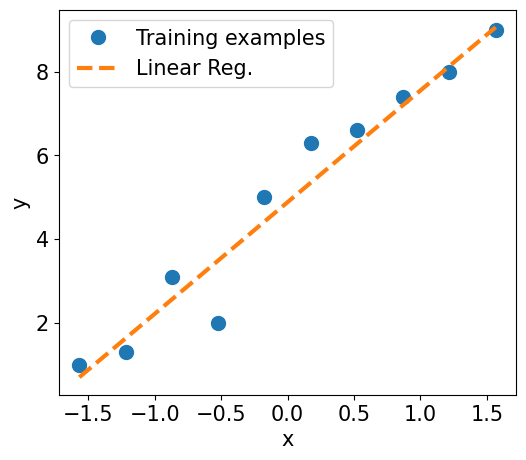

In [8]:
print('Final Parameters:', weight.item(), bias.item())
 
X_test = np.linspace(0, 9, num=100, dtype='float32').reshape(-1, 1)
X_test_norm = (X_test - np.mean(X_train)) / np.std(X_train)
X_test_norm = torch.from_numpy(X_test_norm)
y_pred = model(X_test_norm).detach().numpy()
#detach()方法用于从计算图中分离张量，使其成为一个新的张量，这个新张量不再需要梯度信息。
#在预测模式下，我们不需要计算梯度，因为预测不涉及反向传播。.detach()可以帮助减少内存消耗，并避免不必要的计算。

fig = plt.figure(figsize=(13, 5))
ax = fig.add_subplot(1, 2, 1)
plt.plot(X_train_norm, y_train, 'o', markersize=10)
plt.plot(X_test_norm, y_pred, '--', lw=3)
plt.legend(['Training examples', 'Linear Reg.'], fontsize=15)
ax.set_xlabel('x', size=15)
ax.set_ylabel('y', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

plt.show()

In [9]:
#使用torch.nn和torch.optim模块训练模型
#torch.nn提供了一组损失函数，torch.optim支持常用的优化算法
input_size = 1
output_size = 1
model = nn.Linear(input_size, output_size)      #此处使用Linear类实现线性层，而不是自己编写代码实现

loss_fn = nn.MSELoss(reduction='mean')

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [10]:
for epoch in range(num_epochs):
    for x_batch, y_batch in train_dl:
        # 1. Generate predictions
        pred = model(x_batch)[:, 0] 

        # 2. Calculate loss
        loss = loss_fn(pred, y_batch)

        # 3. Compute gradients
        loss.backward()

        # 4. Update parameters using gradients
        optimizer.step()    #训练模型

        # 5. Reset the gradients to zero
        optimizer.zero_grad()
        
    if epoch % log_epochs==0:
        print(f'Epoch {epoch}  Loss {loss.item():.4f}')

Epoch 0  Loss 24.6684
Epoch 10  Loss 29.1377
Epoch 20  Loss 20.9207
Epoch 30  Loss 0.1257
Epoch 40  Loss 12.4922
Epoch 50  Loss 1.7845
Epoch 60  Loss 7.6425
Epoch 70  Loss 2.5606
Epoch 80  Loss 0.0157
Epoch 90  Loss 0.7548
Epoch 100  Loss 0.8412
Epoch 110  Loss 0.4923
Epoch 120  Loss 0.0823
Epoch 130  Loss 0.0794
Epoch 140  Loss 0.0891
Epoch 150  Loss 0.0973
Epoch 160  Loss 0.1043
Epoch 170  Loss 0.1103
Epoch 180  Loss 0.0009
Epoch 190  Loss 0.0764


In [11]:
print('Final Parameters:', model.weight.item(), model.bias.item())

Final Parameters: 2.6496422290802 4.87706995010376


In [12]:
X_test = np.linspace(0, 9, num=100, dtype='float32').reshape(-1, 1)
X_test_norm = (X_test - np.mean(X_train)) / np.std(X_train)
X_test_norm = torch.from_numpy(X_test_norm)
y_pred = model(X_test_norm).detach().numpy()

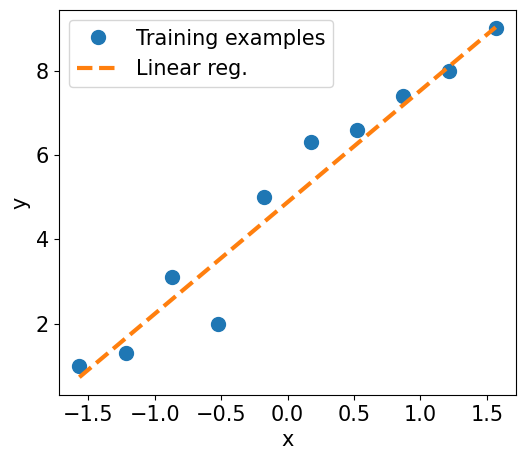

In [13]:
fig = plt.figure(figsize=(13, 5))
ax = fig.add_subplot(1, 2, 1)
plt.plot(X_train_norm, y_train, 'o', markersize=10)
plt.plot(X_test_norm, y_pred, '--', lw=3)
plt.legend(['Training examples', 'Linear reg.'], fontsize=15)
ax.set_xlabel('x', size=15)
ax.set_ylabel('y', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

plt.show()

In [14]:
#12.4.4构建多层感知机对鸢尾花数据集分析
iris = load_iris()
X = iris['data']
y = iris['target']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1./3, random_state=1)

In [15]:
X_train_norm = (X_train - np.mean(X_train)) / np.std(X_train)
X_train_norm = torch.from_numpy(X_train_norm).float()
y_train = torch.from_numpy(y_train) 

In [16]:
train_ds = TensorDataset(X_train_norm, y_train)

torch.manual_seed(1)
batch_size = 2
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

In [17]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)  
        self.layer2 = nn.Linear(hidden_size, output_size)  
        #在本例中使用线性层即可
    def forward(self, x):
        x = self.layer1(x)
        x = nn.Sigmoid()(x)
        x = self.layer2(x)
        x = nn.Softmax(dim=1)(x)
        return x

In [18]:
input_size = X_train_norm.shape[1]
hidden_size = 16
output_size = 3 #因为共有三个类别，所以输出神经元数为3
 
model = Model(input_size, hidden_size, output_size)

learning_rate = 0.001

loss_fn = nn.CrossEntropyLoss()
 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)      #使用Adam优化器，Adam优化器是一个基于梯度的稳定的算法

In [19]:
num_epochs = 100
loss_hist = [0] * num_epochs        #用来保存训练损失
accuracy_hist = [0] * num_epochs    #用来保存训练准确率

for epoch in range(num_epochs):
    for x_batch, y_batch in train_dl:
        pred = model(x_batch)           #注入模型  
        loss = loss_fn(pred, y_batch.long())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
        loss_hist[epoch] += loss.item()*y_batch.size(0)
        is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
        accuracy_hist[epoch] += is_correct.sum()
        
    loss_hist[epoch] /= len(train_dl.dataset)
    accuracy_hist[epoch] /= len(train_dl.dataset)

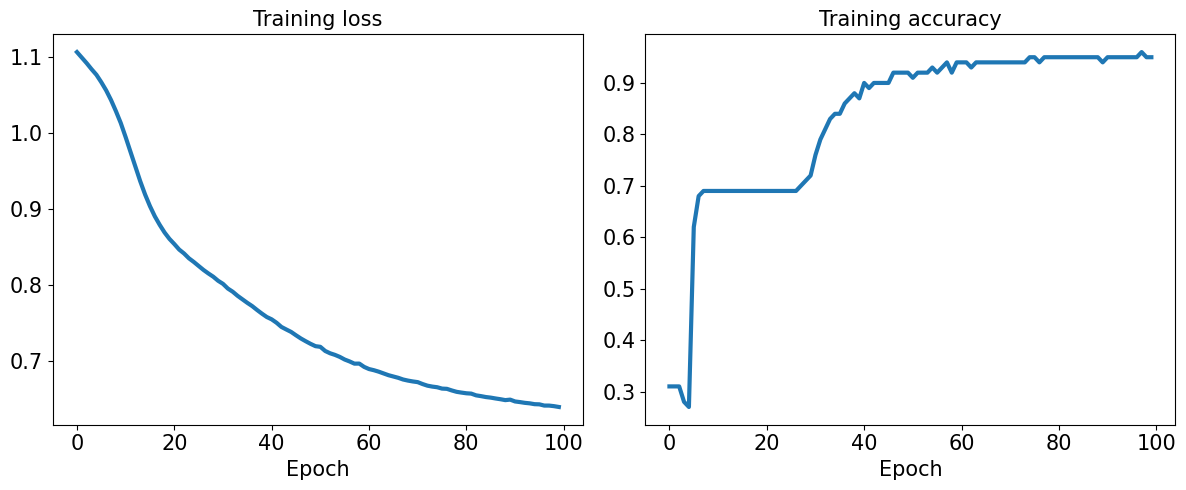

In [20]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(loss_hist, lw=3)
ax.set_title('Training loss', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(accuracy_hist, lw=3)
ax.set_title('Training accuracy', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()
 
plt.show()

In [21]:
#12.4.5在测试数据集上评估训练好的模型
X_test_norm = (X_test - np.mean(X_train)) / np.std(X_train)     #********此处对X_test使用X_train做归一化处理，要对训练集和测试集做同样的归一化*******
X_test_norm = torch.from_numpy(X_test_norm).float()
y_test = torch.from_numpy(y_test) 
pred_test = model(X_test_norm)

correct = (torch.argmax(pred_test, dim=1) == y_test).float()
accuracy = correct.mean()
 
print(f'Test Acc.: {accuracy:.4f}')

Test Acc.: 0.9800


In [22]:
#12.4.6保存和重新加载训练好的模型
path = 'iris_classifier.pt'
torch.save(model, path)

model_new = torch.load(path)
model_new.eval()

C:\Users\Leo\AppData\Local\Temp\ipykernel_5388\1330346021.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_new = torch.load(path)


Model(
  (layer1): Linear(in_features=4, out_features=16, bias=True)
  (layer2): Linear(in_features=16, out_features=3, bias=True)
)

In [23]:
pred_test = model_new(X_test_norm)

correct = (torch.argmax(pred_test, dim=1) == y_test).float()
accuracy = correct.mean()
 
print(f'Test Acc.: {accuracy:.4f}')

Test Acc.: 0.9800


In [24]:
path = 'iris_classifier_state.pt'
torch.save(model.state_dict(), path)

model_new = Model(input_size, hidden_size, output_size)
model_new.load_state_dict(torch.load(path))

C:\Users\Leo\AppData\Local\Temp\ipykernel_5388\223149007.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_new.load_state_dict(torch.load(path))


<All keys matched successfully>

In [25]:
###12.5 为多层神经网络选择激活函数
#12.5.1回归逻辑函数，实际是sigmoid函数的一个特例，即净输入z=W^T * x，逻辑函数σ(z)=1/(1-np.exp(-z))

X = np.array([1, 1.4, 2.5]) ## first value must be 1
w = np.array([0.4, 0.3, 0.5])

In [26]:
def net_input(X, w):
    return np.dot(X, w)

def logistic(z):
    return 1.0 / (1.0 + np.exp(-z))

def logistic_activation(X, w):
    z = net_input(X, w)
    return logistic(z)

In [27]:
print(f'P(y=1|x) = {logistic_activation(X, w):.3f}') 

P(y=1|x) = 0.888


In [28]:
# W : array with shape = (n_output_units, n_hidden_units+1)
# note that the first column are the bias units

W = np.array([[1.1, 1.2, 0.8, 0.4],
              [0.2, 0.4, 1.0, 0.2],
              [0.6, 1.5, 1.2, 0.7]])

# A : data array with shape = (n_hidden_units + 1, n_samples)
# note that the first column of this array must be 1

A = np.array([[1, 0.1, 0.4, 0.6]])
Z = np.dot(W, A[0])
y_probas = logistic(Z)
print('Net Input: \n', Z)

print('Output Units:\n', y_probas) 


Net Input: 
 [1.78 0.76 1.65]
Output Units:
 [0.85569687 0.68135373 0.83889105]


In [29]:
y_class = np.argmax(Z, axis=0)
print('Predicted class label:', y_class) 

Predicted class label: 0


In [30]:
#12.5.2使用softmax函数估计多分类中的类别概率
#softmax函数是argmax函数的软形式，不给出单个类的索引，而是给出每个类的预测概率，因此可以在多分类模型中计算预测类别的概率
def softmax(z):
    return np.exp(z) / np.sum(np.exp(z))

In [31]:
y_probas = softmax(Z)
print('Probabilities:\n', y_probas)

np.sum(y_probas)

Probabilities:
 [0.44668973 0.16107406 0.39223621]


1.0

In [32]:
torch.softmax(torch.from_numpy(Z), dim=0)

tensor([0.4467, 0.1611, 0.3922], dtype=torch.float64)

<>:15: SyntaxWarning: invalid escape sequence '\p'
<>:15: SyntaxWarning: invalid escape sequence '\p'
C:\Users\Leo\AppData\Local\Temp\ipykernel_5388\2432038143.py:15: SyntaxWarning: invalid escape sequence '\p'
  plt.ylabel('Activation $\phi(z)$')


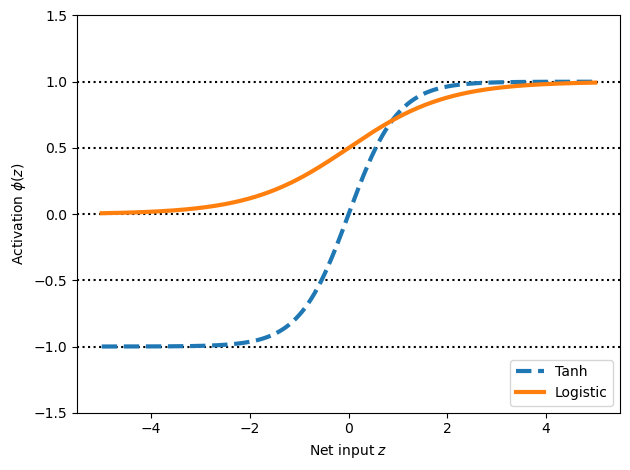

In [33]:
#使用双曲正切函数拓宽输出范围
#双曲正切函数tan h是一个S形函数，常用于神经网络的隐藏层中，可以将其解释为尺度缩放后的逻辑函数,值域为（-1，1）
#σtanh(z) = 2*σlogistic(2z) - 1 = (np.exp(z)-np.exp(-z))/(np.exp(z)+np.exp(-z))

def tanh(z):
    e_p = np.exp(z)
    e_m = np.exp(-z)
    return (e_p - e_m) / (e_p + e_m)

z = np.arange(-5, 5, 0.005)
log_act = logistic(z)
tanh_act = tanh(z)
plt.ylim([-1.5, 1.5])
plt.xlabel('Net input $z$')
plt.ylabel('Activation $\phi(z)$')
plt.axhline(1, color='black', linestyle=':')
plt.axhline(0.5, color='black', linestyle=':')
plt.axhline(0, color='black', linestyle=':')
plt.axhline(-0.5, color='black', linestyle=':')
plt.axhline(-1, color='black', linestyle=':')
plt.plot(z, tanh_act,
    linewidth=3, linestyle='--',
    label='Tanh')
plt.plot(z, log_act,
    linewidth=3,
    label='Logistic')
plt.legend(loc='lower right')
plt.tight_layout()

plt.show()

In [34]:
np.tanh(z)

torch.tanh(torch.from_numpy(z))

tensor([-0.9999, -0.9999, -0.9999,  ...,  0.9999,  0.9999,  0.9999],
       dtype=torch.float64)

In [35]:
expit(z)

array([0.00669285, 0.00672617, 0.00675966, ..., 0.99320669, 0.99324034,
       0.99327383])

In [36]:
torch.sigmoid(torch.from_numpy(z))

tensor([0.0067, 0.0067, 0.0068,  ..., 0.9932, 0.9932, 0.9933],
       dtype=torch.float64)

In [37]:
#整流线性单元ReLU
#σ(z) = max(0,z)，仍是一个非线性函数，且对正值输入的导数始终为1，解决了梯度消失问题，有利于神经网络学习复杂函数，
torch.relu(torch.from_numpy(z))

tensor([0.0000, 0.0000, 0.0000,  ..., 4.9850, 4.9900, 4.9950],
       dtype=torch.float64)